In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/src/script.ipynb
/kaggle/lib/kaggle/gcp.py
/kaggle/input/200-bird-species-with-11788-images/CUB_200_2011.tgz
/kaggle/input/200-bird-species-with-11788-images/segmentations.tgz
/kaggle/working/__notebook__.ipynb


In [2]:
!ls

__notebook__.ipynb


In [3]:
!mkdir -p '/kaggle/temp/'
#!tar -xvzf '../input/200-bird-species-with-11788-images/CUB_200_2011.tgz' --directory '/kaggle/temp/'
!tar -xzf '../input/200-bird-species-with-11788-images/CUB_200_2011.tgz' --directory '/kaggle/temp/'

In [4]:
import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./__notebook__.ipynb


In [5]:
#%%
import tensorflow as tf
print('TF version: ', tf.__version__)

#%% 
# """fix for issue: cuDNN failed to initialize"""
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# if len(physical_devices)>0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)
#     print('...GPU set_memory_growth successfully set...')

# else:
#     print('...GPU set_memory_growth not set...')

#%%
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten,Softmax, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import math
#from tf_explain_modified.core.grad_cam import GradCAM
import datetime
from tqdm import tqdm # to monitor progress
import argparse
import os, sys
from tensorflow.keras.applications.vgg16 import VGG16,decode_predictions, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


from tensorflow.keras import optimizers


# from models10 import MySubClassModel
# from codes.compute_filter_importance import save_filter_importance, test_filter_importance,test_filter_importance_in_code_method, plot_filter_importance,check_top_filter_importance,save_filter_importance_batch, check_histogram_top_filter_result
# from codes.load_cxr_dataset import create_cxr_dataframes, load_cxr_dataset
# from codes.support_functions import print_filter_classes_1, print_filter_classes_2, save_interpretable_parameters
# from codes.find_filter_class import find_filter_class
# from codes.train_counterfactual_net import train_counterfactual_net
# from codes.support_functions import get_heatmap_only

TF version:  2.3.1


In [6]:
#%%
KAGGLE = True
parser = argparse.ArgumentParser(description='Interpretable CNN')
parser.add_argument('--interpretable',default = False)
parser.add_argument('--full_standard',default = True)## dont add extra cnn layer to be comparable with interpretable model. Make completely standalone model
parser.add_argument('--train_using_builtin_fit_method',default = True)#for training base model easily

parser.add_argument('--create_counterfactual_combined' ,default = False)## create CF model for a pretrained base model or train a new base model

parser.add_argument('--train_counterfactual_net' ,default = False)## 
parser.add_argument('--resume_counterfactual_net' ,default = False)## 
parser.add_argument('--test_counterfactual_net' ,default = False)## 
parser.add_argument('--load_counterfactual_net',default = True)


parser.add_argument('--resume', default =False) # load saved weights for base model
parser.add_argument('--pretrained', default = False) # load self-pretrained model

parser.add_argument('--find_filter_class', default = False) # load retrained model and assign class to each filter by check mean activation per filter per class

parser.add_argument('--filter_modified_directly', default = True)
parser.add_argument('--loss_compute', default = True)#False = forward only
parser.add_argument('--high_capacity_model', default = True)#
parser.add_argument('--fixed_classes', default = True)#idea 2: fine tune from forward only with fixed classes
parser.add_argument('--fixed_classes_reduce_loss', default = True)#False = forward only masked with fixed filter class. issue: 100% training accuracy but 10% testing acc

parser.add_argument('--test_filter_importance', default = False)#for testing idea 2
parser.add_argument('--save_filter_importance', default = False)#for testing idea 2
parser.add_argument('--analyze_filter_importance', default = False)#for testing idea 2
parser.add_argument('--save_filter_fmap', default = False)#save filter fmap as well
parser.add_argument('--save_top_layer', default = True)#save top layer filter data only

parser.add_argument('--visualize_fmaps', default = False)

#base model parameters
parser.add_argument('--dataset',default = 'CUB200')#mnist, cifar10, CUB200, #cxr1000, #catsvsdogs, #VOC2010
parser.add_argument('--save_directory',default = './trained_weights/')
parser.add_argument('--train',default = True)
parser.add_argument('--test', default = True)
parser.add_argument('--model',default = 'VGG16/')#myCNN, VGG16
parser.add_argument('--imagenet_weights',default = True) #use imageNet pretrained VGG

parser.add_argument('--filter_category_method',default = 'own_reduce_loss')   # paper --> similar to paper implementation---assign filter with categories during training by accumulating batch-wise max activations
                                                                    # own_reduce_loss --> our idea - pre-assign filter categories during forward pass over all the data, based on pretrained weights and feature maps


#parser.add_argument('--test',default = True)
 
if KAGGLE: args = parser.parse_known_args()[0] 
else: args = parser.parse_args()

if args.interpretable:
    if args.filter_category_method=='paper':
        print('filter category assignment --> paper method')
    else:
        print('filter category assignment --> our idea')
    weights_path = args.save_directory+args.model+args.dataset+'/interpretable/filter_category_method_'+str(args.filter_category_method)
    log_path  = './logs/'+args.model+args.dataset+'/interpretable/filter_category_method_'+str(args.filter_category_method)
    filter_data_path = './create_training_data/'+args.model+args.dataset+'/interpretable/filter_category_method_'+str(args.filter_category_method)
else:
    weights_path = args.save_directory+args.model+args.dataset+'/standard'
    log_path  = './logs/'+args.model+args.dataset+'/standard'
    filter_data_path = './create_training_data/'+args.model+args.dataset+'/standard' #directory for saving filter importance training data
    
if not os.path.exists(weights_path):
    os.makedirs(weights_path)    
print('save_path: ',weights_path)

parser.add_argument('--save_path',default = weights_path)
if KAGGLE: args = parser.parse_known_args()[0] 
else: args = parser.parse_args()

if args.resume:
    print("resuming training")
#print(args)

save_path:  ./trained_weights/VGG16/CUB200/standard


In [7]:
#%%
batch_size = 32
if args.dataset == 'mnist':
    num_classes=10
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = np.expand_dims(x_train,-1)
    x_test = np.expand_dims(x_test,-1)
    input_shape = (batch_size,28,28,1)
    label_map = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

elif args.dataset == 'cifar10':
    num_classes=10
    print('cifar-10 dataset')
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    input_shape = (batch_size,32,32,3)
    label_map = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

elif args.dataset == 'CUB200':
    print('CUB200-2011 dataset')
    num_classes=200
    input_shape = (batch_size,224,224,3)
    if KAGGLE: base_path = '/kaggle/temp/CUB_200_2011'
    else: base_path = 'G:/CUB_200_2011/CUB_200_2011'
    
    data_dir =base_path+'/images/'
    label_map = np.loadtxt(fname=base_path + '/classes.txt',dtype='str')
    label_map = label_map[:,1]

elif args.dataset == 'cxr1000':
    print('CXR-1000 dataset')
    num_classes=15
    input_shape = (batch_size,224,224,3)
    label_map, train_df, test_df, valid_df = create_cxr_dataframes()
    all_labels = label_map
elif args.dataset == 'catsvsdogs':
    print('catsvsdogs dataset')
    num_classes=2
    input_shape = (batch_size,224,224,3)
    lab_system = False
    if lab_system:
        data_dir ='D:/Ali Tariq/catsvsdogs/train/'
        data_dir_test ='D:/Ali Tariq/catsvsdogs/test/'    
    else:
        data_dir ='G:/catsvsdogs/train/'
        data_dir_test ='G:/catsvsdogs/test/'

    label_map = ['cat',  'dog']

elif args.dataset == 'VOC2010':
    print('VOC2010-animals dataset')
    num_classes=6
    input_shape = (batch_size,224,224,3)
    lab_system = False
    if lab_system:
        data_dir ='D:/Ali Tariq/VOCdevkit/VOC_animals/'
        #data_dir_test ='D:/Ali Tariq/catsvsdogs/test/'    
    else:
        #data_dir ='G:/VOCdevkit/VOC_animals_one/'
        data_dir ='G:/VOCdevkit/VOC_animals/'
        #data_dir_test ='G:/catsvsdogs/test/'

    label_map = ['bird',  'cat', 'cow', 'dog', 'horse', 'sheep']#['cat']#

else:
    print('unknown dataset')
    sys.exit()

CUB200-2011 dataset


In [8]:
label_map

array(['001.Black_footed_Albatross', '002.Laysan_Albatross',
       '003.Sooty_Albatross', '004.Groove_billed_Ani',
       '005.Crested_Auklet', '006.Least_Auklet', '007.Parakeet_Auklet',
       '008.Rhinoceros_Auklet', '009.Brewer_Blackbird',
       '010.Red_winged_Blackbird', '011.Rusty_Blackbird',
       '012.Yellow_headed_Blackbird', '013.Bobolink',
       '014.Indigo_Bunting', '015.Lazuli_Bunting', '016.Painted_Bunting',
       '017.Cardinal', '018.Spotted_Catbird', '019.Gray_Catbird',
       '020.Yellow_breasted_Chat', '021.Eastern_Towhee',
       '022.Chuck_will_Widow', '023.Brandt_Cormorant',
       '024.Red_faced_Cormorant', '025.Pelagic_Cormorant',
       '026.Bronzed_Cowbird', '027.Shiny_Cowbird', '028.Brown_Creeper',
       '029.American_Crow', '030.Fish_Crow', '031.Black_billed_Cuckoo',
       '032.Mangrove_Cuckoo', '033.Yellow_billed_Cuckoo',
       '034.Gray_crowned_Rosy_Finch', '035.Purple_Finch',
       '036.Northern_Flicker', '037.Acadian_Flycatcher',
       '038.Grea

In [9]:
#%%
if args.imagenet_weights:
    print('using imagenet_weights')

    if args.dataset == 'cifar10':
        imgDataGen = ImageDataGenerator(preprocessing_function = preprocess_input)
                                        #rescale = 1./255)

        train_gen = imgDataGen.flow(x_train, y_train, batch_size = batch_size,shuffle= False)
        test_gen  = imgDataGen.flow(x_test, y_test, batch_size = batch_size,shuffle= False)
    else:
        augment = False
        if not augment:
            imgDataGen = ImageDataGenerator(preprocessing_function = preprocess_input, 
                                            #rescale = 1./255,
                                            validation_split=0.2)
        else:
            imgDataGen = ImageDataGenerator(preprocessing_function = preprocess_input, 
                                        #rescale = 1./255,
                                        validation_split=0.2,
                                        
                              height_shift_range= 0.2, 
                              width_shift_range=0.2, 
                              rotation_range=15, 
                              shear_range = 0.2,
                              fill_mode = 'nearest',#''nearest#reflect
                              zoom_range=0.2)
        
        train_gen = imgDataGen.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=True,
                                seed=None,
                                subset='training',
                                interpolation='nearest')#,
                                #all classes for base model; binary classes for CF model
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = label_map)
        test_gen  = imgDataGen.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=False,
                                seed=None,
                                subset='validation',
                                interpolation='nearest')#,
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                               # classes = label_map)
        
        # for visualization, dont use preprocessed image
        imgDataGen_nopreprocess = ImageDataGenerator(#preprocessing_function = preprocess_input, 
                                        rescale = 1./255,
                                        validation_split=0.2)
        
        train_gen_nopreprocess = imgDataGen_nopreprocess.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=True,
                                seed=None,
                                subset='training',
                                interpolation='nearest'),
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = label_map)
        test_gen_nopreprocess  = imgDataGen_nopreprocess.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=False,
                                seed=None,
                                subset='validation',
                                interpolation='nearest'),
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = label_map)
elif args.dataset == 'cxr1000':
    train_gen, test_gen, valid_gen = load_cxr_dataset(train_df, test_df, valid_df, all_labels, batch_size)
    
else:
    print('not using imagenet_weights')

    imgDataGen = ImageDataGenerator(rescale = 1./255)

    train_gen = imgDataGen.flow(x_train, y_train, batch_size = batch_size,shuffle= False)
    test_gen  = imgDataGen.flow(x_test, y_test, batch_size = batch_size,shuffle= False)



using imagenet_weights
Found 9465 images belonging to 200 classes.
Found 2323 images belonging to 200 classes.
Found 9465 images belonging to 200 classes.
Found 2323 images belonging to 200 classes.


In [10]:
#%%
if args.imagenet_weights:
    print('loading VGG model')
    if args.dataset == 'cxr1000':
        tr = 1
        if tr:
            print('using imagenet weights for CXR dataset')
            vgg = VGG16(weights='imagenet',include_top = True)#top needed to get output dimensions at each layer
                # EfficientNetB0(include_top=True,
                #                weights=None,
                #                input_shape=img_shape,
                #                classes=len(all_labels),
                #                classifier_activation='sigmoid')
            base_model = tf.keras.Model(vgg.input,vgg.layers[-6].output)
            #model.compile(optimizer = optimizers.RMSprop(), loss = 'binary_crossentropy',#adam #weighted_binary_crossentropy #lr=0.001/2#binary_crossentropy
                                       #metrics = ['binary_accuracy'])#,tf.keras.metrics.AUC()])
        else:
            print('loading saved model - NOT IMPLEMENTED YET')
            #model = load_model('../input/efnb0-saved-weights/xray_class_EfficientNetB4_15_class_CEL_heatmap_imagenet_pretrained_weights.05-0.1807.hdf5')
        
        #model.summary()
    elif args.dataset == 'cifar10':
        print('using imagenet weights for cifar10 dataset')
        vgg = VGG16(weights='imagenet',include_top = False,input_shape=(32,32,3))#top needed to get output dimensions at each layer
        freeze=True
        if freeze:
            for layer in vgg.layers:
                layer.trainable = False
        base_model = tf.keras.Model(vgg.input,vgg.layers[-2].output)
    elif args.dataset == 'CUB200':
       print('using imagenet weights for CUB200 dataset')
       vgg = VGG16(weights='imagenet',include_top = False,input_shape=(224,224,3))#top needed to get output dimensions at each layer
       freeze=True
       if freeze:
           for layer in vgg.layers:
               print (layer.name)
               if layer.name == '----block5_conv3': continue
               else: layer.trainable = False
       base_model = tf.keras.Model(vgg.input,vgg.layers[-2].output)
    elif args.dataset == 'catsvsdogs':
        print('using imagenet weights for catsvsdogs dataset')
        vgg = VGG16(weights='imagenet',include_top = False,input_shape=(224,224,3))#top needed to get output dimensions at each layer
        freeze=True
        if freeze:
            for layer in vgg.layers:
                layer.trainable = False
        base_model = tf.keras.Model(vgg.input,vgg.layers[-2].output)
    elif args.dataset == 'VOC2010':
        print('using imagenet weights for VOC2010-animals dataset')
        vgg = VGG16(weights='imagenet',include_top = False,input_shape=(224,224,3))#top needed to get output dimensions at each layer
        freeze=True
        if freeze:
            for layer in vgg.layers:
                layer.trainable = False
        base_model = tf.keras.Model(vgg.input,vgg.layers[-2].output)
else:
    #base_model = VGG16(weights=None,include_top = False)
    base_model = MyFunctionalModel()


loading VGG model
using imagenet weights for CUB200 dataset
58892288/58889256 [==============================] - 0s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [11]:
#%% create base model
if args.full_standard:
    top_filters = base_model.output_shape[3] # flters in top conv layer (512 for VGG)
    fmatrix = tf.keras.layers.Input(shape=(top_filters))
    #flag = tf.keras.layers.Input(shape=(1))
    
    x =  MaxPool2D()(base_model.output)
    mean_fmap = GlobalAveragePooling2D()(x)
    

    
    #modify base model (once it has been pre-trained separately) to be used with CF model later
    if args.create_counterfactual_combined:
        #modified_fmap = tf.cond(tf.reduce_sum(fmatrix)>511, lambda: mean_fmap, lambda: mean_fmap*fmatrix)#modified_fmap = mean_fmap*fmatrix
        modified_fmap = mean_fmap*fmatrix
        pre_softmax = Dense(num_classes,activation=None)(modified_fmap)
        x = tf.keras.layers.Activation('softmax')(pre_softmax)
        model = tf.keras.Model(inputs=[base_model.input, fmatrix], outputs= [x,base_model.output, mean_fmap, modified_fmap,pre_softmax],name='VGG_base_model')
        default_fmatrix = tf.ones((train_gen.batch_size,base_model.output.shape[3]))
    else:
        x = tf.keras.layers.Dropout(0.5)(mean_fmap)
        
        #x = Dense(512,activation='relu')(x)
        #x = tf.keras.layers.Dropout(0.2)(x)
        
        #x = Dense(512,activation='relu')(x)

        x = Dense(num_classes,activation='softmax')(x)
        if args.train_using_builtin_fit_method:
            model = tf.keras.Model(inputs=base_model.input, outputs= [x])#, base_model.output])
        else:
            model = tf.keras.Model(inputs=base_model.input, outputs= [x, base_model.output])
else:
    model = MySubClassModel(num_classes=num_classes, base_model=base_model, args=args)
    #model = base_model
    model(tf.zeros(input_shape))
    #model.build(input_shape = input_shape)

model.summary()

#model.load_weights('./trained_weights/VGG16/CUB200/standard/model.09-2.3280.hdf5')
#load saved weights
if args.resume:
    #model.load_weights('./trained_weights/myCNN/cifar10/standard/model.hdf5')
    #model.load_weights('./trained_weights/myCNN/cifar10/interpretable/filter_category_method_paper/from_pretrained_model.hdf5')
    model.load_weights(filepath=weights_path+'/model.hdf5')
    #model.load_weights('./trained_weights/myCNN/cifar10/interpretable/filter_category_method_paper/model.hdf5')

    print("weights loaded")
if args.pretrained:
    model.load_weights('./trained_weights/myCNN/cifar10/standard/model.hdf5')
    print("pretrained weights loaded")

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

Epoch 1/20
296/296 [==============================] - ETA: 0s - loss: 16.0888 - accuracy: 0.0361
Epoch 00001: val_loss improved from inf to 4.93107, saving model to ./trained_weights/VGG16/CUB200/standard/model.01-4.9311.hdf5
296/296 [==============================] - 67s 227ms/step - loss: 16.0888 - accuracy: 0.0361 - val_loss: 4.9311 - val_accuracy: 0.2092
Epoch 2/20
296/296 [==============================] - ETA: 0s - loss: 8.2557 - accuracy: 0.1623
Epoch 00002: val_loss improved from 4.93107 to 3.37905, saving model to ./trained_weights/VGG16/CUB200/standard/model.02-3.3791.hdf5
296/296 [==============================] - 64s 217ms/step - loss: 8.2557 - accuracy: 0.1623 - val_loss: 3.3791 - val_accuracy: 0.3711
Epoch 3/20
296/296 [==============================] - ETA: 0s - loss: 5.3825 - accuracy: 0.2837
Epoch 00003: val_loss improved from 3.37905 to 2.75301, saving model to ./trained_weights/VGG16/CUB200/standard/model.03-2.7530.hdf5
296/296 [==============================] - 65s 

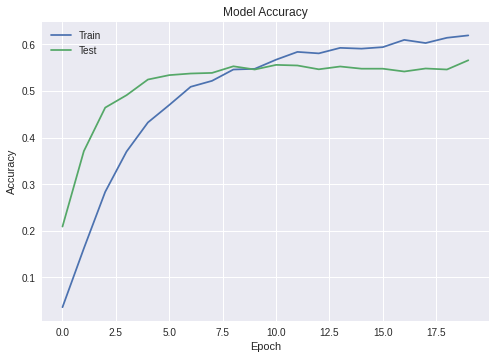

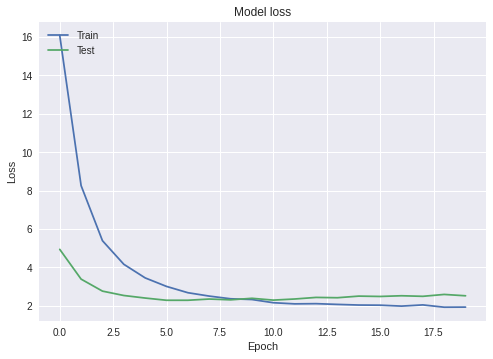

In [12]:
#%% Trains for 5 epochs.
if args.train_using_builtin_fit_method:

    model.compile(optimizer=Adam(lr=0.001/1), 
                  loss=[categorical_crossentropy], 
                  metrics=['accuracy'])


    #%%
    save_path=weights_path+'/model.{epoch:02d}-{val_loss:.4f}.hdf5'
    checkpoint = ModelCheckpoint(save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = True)
    callbacks_list = [checkpoint]
    #%%
    history = model.fit(train_gen, epochs=20, verbose=1, callbacks=callbacks_list, validation_data=test_gen, shuffle=True)
    
    plt.style.use('seaborn')
    #plt.style.available
    #['fivethirtyeight',
     #'seaborn-pastel',
     #'seaborn-whitegrid',
     #'ggplot',
     #'grayscale']
    
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #plt.savefig(fname='model_accuracy_'+db+'.png')
    
    # summarize history for loss
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #plt.savefig(fname='model_loss_'+db+'.png')
    
    #%% stop execution
    #sys.exit()

# **Now fine tune all layers at small learning rate**

In [13]:
model.trainable = True
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

# enable augmentation for increasing regularization for fine-tuning step

In [14]:
if args.imagenet_weights:
    print('using imagenet_weights')

    if args.dataset == 'cifar10':
        imgDataGen = ImageDataGenerator(preprocessing_function = preprocess_input)
                                        #rescale = 1./255)

        train_gen = imgDataGen.flow(x_train, y_train, batch_size = batch_size,shuffle= False)
        test_gen  = imgDataGen.flow(x_test, y_test, batch_size = batch_size,shuffle= False)
    else:
        augment = True
        if not augment:
            imgDataGen = ImageDataGenerator(preprocessing_function = preprocess_input, 
                                            #rescale = 1./255,
                                            validation_split=0.2)
        else:
            imgDataGen = ImageDataGenerator(preprocessing_function = preprocess_input, 
                                        #rescale = 1./255,
                                        validation_split=0.2,
                                        
                              height_shift_range= 0.2, 
                              width_shift_range=0.2, 
                              rotation_range=15, 
                              shear_range = 0.2,
                              fill_mode = 'nearest',#''nearest#reflect
                              zoom_range=0.2)
        
        train_gen = imgDataGen.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=True,
                                seed=None,
                                subset='training',
                                interpolation='nearest')#,
                                #all classes for base model; binary classes for CF model
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = label_map)
        test_gen  = imgDataGen.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=False,
                                seed=None,
                                subset='validation',
                                interpolation='nearest')#,
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                               # classes = label_map)
        
        # for visualization, dont use preprocessed image
        imgDataGen_nopreprocess = ImageDataGenerator(#preprocessing_function = preprocess_input, 
                                        rescale = 1./255,
                                        validation_split=0.2)
        
        train_gen_nopreprocess = imgDataGen_nopreprocess.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=True,
                                seed=None,
                                subset='training',
                                interpolation='nearest'),
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = label_map)
        test_gen_nopreprocess  = imgDataGen_nopreprocess.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=False,
                                seed=None,
                                subset='validation',
                                interpolation='nearest'),
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = label_map)
elif args.dataset == 'cxr1000':
    train_gen, test_gen, valid_gen = load_cxr_dataset(train_df, test_df, valid_df, all_labels, batch_size)
    
else:
    print('not using imagenet_weights')

    imgDataGen = ImageDataGenerator(rescale = 1./255)

    train_gen = imgDataGen.flow(x_train, y_train, batch_size = batch_size,shuffle= False)
    test_gen  = imgDataGen.flow(x_test, y_test, batch_size = batch_size,shuffle= False)

using imagenet_weights
Found 9465 images belonging to 200 classes.
Found 2323 images belonging to 200 classes.
Found 9465 images belonging to 200 classes.
Found 2323 images belonging to 200 classes.


Epoch 1/50
296/296 [==============================] - ETA: 0s - loss: 1.6058 - accuracy: 0.5730
Epoch 00001: val_loss improved from inf to 1.47115, saving model to ./trained_weights/VGG16/CUB200/standard/model.01-1.4712.hdf5
296/296 [==============================] - 193s 652ms/step - loss: 1.6058 - accuracy: 0.5730 - val_loss: 1.4712 - val_accuracy: 0.6147
Epoch 2/50
296/296 [==============================] - ETA: 0s - loss: 1.2921 - accuracy: 0.6348
Epoch 00002: val_loss improved from 1.47115 to 1.35100, saving model to ./trained_weights/VGG16/CUB200/standard/model.02-1.3510.hdf5
296/296 [==============================] - 200s 677ms/step - loss: 1.2921 - accuracy: 0.6348 - val_loss: 1.3510 - val_accuracy: 0.6410
Epoch 3/50
296/296 [==============================] - ETA: 0s - loss: 1.1472 - accuracy: 0.6692
Epoch 00003: val_loss improved from 1.35100 to 1.34496, saving model to ./trained_weights/VGG16/CUB200/standard/model.03-1.3450.hdf5
296/296 [==============================] - 198s

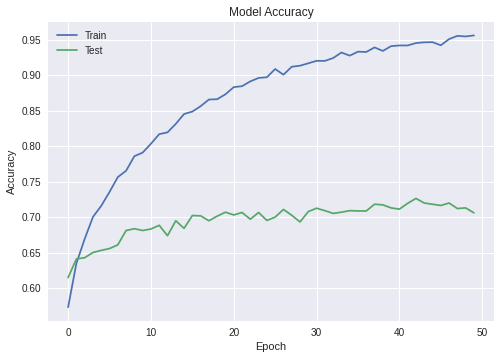

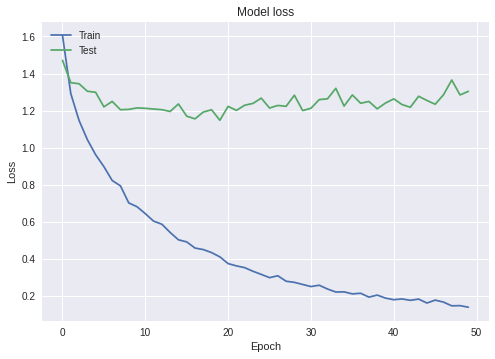

In [15]:
#%% Trains for 5 epochs.
if args.train_using_builtin_fit_method:
    
    model.compile(optimizer=Adam(lr=0.001/100), 
                  loss=[categorical_crossentropy], 
                  metrics=['accuracy'])


    #%%
    save_path=weights_path+'/model.{epoch:02d}-{val_loss:.4f}.hdf5'
    checkpoint = ModelCheckpoint(save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = True)
    callbacks_list = [checkpoint]
    #%%
    history = model.fit(train_gen, epochs=50, verbose=1, callbacks=callbacks_list, validation_data=test_gen, shuffle=True)
    
    plt.style.use('seaborn')
    #plt.style.available
    #['fivethirtyeight',
     #'seaborn-pastel',
     #'seaborn-whitegrid',
     #'ggplot',
     #'grayscale']
    
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #plt.savefig(fname='model_accuracy_'+db+'.png')
    
    # summarize history for loss
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #plt.savefig(fname='model_loss_'+db+'.png')
    
    #%% stop execution
    #sys.exit()

In [16]:
import os
for dirname, _, filenames in os.walk('./trained_weights'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./trained_weights/VGG16/CUB200/standard/model.14-1.1956.hdf5
./trained_weights/VGG16/CUB200/standard/model.06-1.2206.hdf5
./trained_weights/VGG16/CUB200/standard/model.04-2.5250.hdf5
./trained_weights/VGG16/CUB200/standard/model.03-1.3450.hdf5
./trained_weights/VGG16/CUB200/standard/model.17-1.1558.hdf5
./trained_weights/VGG16/CUB200/standard/model.06-2.2760.hdf5
./trained_weights/VGG16/CUB200/standard/model.05-2.3919.hdf5
./trained_weights/VGG16/CUB200/standard/model.16-1.1703.hdf5
./trained_weights/VGG16/CUB200/standard/model.02-3.3791.hdf5
./trained_weights/VGG16/CUB200/standard/model.02-1.3510.hdf5
./trained_weights/VGG16/CUB200/standard/model.05-1.2990.hdf5
./trained_weights/VGG16/CUB200/standard/model.20-1.1482.hdf5
./trained_weights/VGG16/CUB200/standard/model.08-1.2050.hdf5
./trained_weights/VGG16/CUB200/standard/model.01-1.4712.hdf5
./trained_weights/VGG16/CUB200/standard/model.01-4.9311.hdf5
./trained_weights/VGG16/CUB200/standard/model.03-2.7530.hdf5
./trained_weights/VGG16/